# Web Scraping & NLP
- Scraping article text from a website using BeautifulSoup
- Performing sentiment analysis on article content using SpaCy
- Summarizig article content into key information using SpaCy


### Setup

In [1]:
import requests
from bs4 import BeautifulSoup
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import numpy as np

# formatting helper
dashes = "-" * 50
dash_short = "-" * 22

### Scrape Text 
- Copy format below to add any number of websites
- Update html and css attributes and tags based on website source code
    - The goal here is to pull the text from the site as cleanly as possible minus extra links or images
- Update the article_content and article_labels lists at the end to include all sites

In [2]:
# set up for first article
article1_url = 'https://www.mckinsey.com/industries/healthcare/our-insights/driving-growth-through-consumer-centricity-in-healthcare'
article1_label = "consumer-centricity-in-healthcare.html"
article1_page = requests.get(article1_url)
article1_html = article1_page.text     
soup1 = BeautifulSoup(article1_html, 'html5lib')    
# remove footnote links
for f in soup1.find_all('span', attrs={"class": "FootNote_footnote-holder__7oYio"}):
    f.a.extract()
article1_content = soup1.find(class_="mdc-u-grid mdc-u-grid-gutter-xxl").get_text() 
article1_content = article1_content.replace('\n', ' ').replace('  ',' ')
article1_content = str([re.sub('[^A-Za-z0-9!//\\{}$&%*#@<>.,?_\- \"\']+', '', w) for w in [article1_content]])
with open("scraped-"+article1_label, "w", encoding = 'utf-8') as file1:
    file1.write(article1_content)

# set up for second article
article2_url = 'https://www.mckinsey.com/industries/healthcare/our-insights/women-in-healthcare-and-life-sciences-the-ongoing-stress-of-covid-19'
article2_label = "women-in-healthcare.html"
article2_page = requests.get(article2_url)
article2_html = article2_page.text
soup2 = BeautifulSoup(article2_html, 'html5lib')  
soup2.decode('utf-8')
# remove images and links
for i in soup2.find_all(attrs={"class": "mck-c-inline-module-container mck-o-md-center"}):
    i.extract()
for i in soup2.find_all(attrs={"class": "mck-c-inline-module-container mck-o-sm-left-span"}):
    i.extract()

article2_content = soup2.find(class_="mdc-u-grid mdc-u-grid-gutter-xxl").get_text() 
article2_content = article2_content.replace('\n', ' ').replace('  ',' ')
article2_content = str([re.sub('[^A-Za-z0-9!//\\{}$&%*#@<>.,?_\- \"\']+', '', w) for w in [article2_content]])
with open("scraped-"+article2_label, "w", encoding = 'utf-8') as file2:
    file2.write(article2_content)

# -------------------------------------------------------------- # 

# create a list of all articles' content & their labels
article_content = [article1_content, article2_content]
article_labels = [article1_label, article2_label]   
#print("\nARTICLE CONTENT:\n", article_content[1])   


### Sentiment Analysis Function

In [3]:
def polarity_score(content, label):
    ''' perform sentiment analysis for polarity on a given set of content '''
    
    # load the spacy model
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe('spacytextblob')
    
    # do sentiment analysis 
    doc = nlp(content)

    polarity = doc._.blob.polarity
    polarity_label = 'Positive' if polarity > 0.05 else 'Negative' if polarity < -0.05 else 'Neutral'            

    print("POLARITY RESULTS:")
    print(dash_short)
    print(f"Polarity Score: {round(polarity,3)}")
    print(f"Sentiment: {polarity_label}")  


### Summarization Functions

In [4]:
def we_care_about(token):
    ''' function to remove whitepace, stopwords, and punctuation '''
    
    return not (token.is_space or token.is_punct or token.is_stop)

def plot_histogram(scores, label):
    ''' plot a histogram of score frequency '''
    
    plt.rcParams["figure.figsize"] = (4,3)
    plt.hist(scores)
    plt.suptitle('Frequency of Sentence Scores', y=1)
    plt.title(label, fontsize=10, y=0.98)
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.savefig('images/scores-'+label+'.png', bbox_inches='tight')
    plt.show()  

def create_wordcloud(content, label):
    ''' create a word cloud '''
    
    wc = WordCloud(width = 5000, height = 2000,
               random_state=15, background_color='#e6f4fd',
               max_words=25, colormap='winter', collocations = False,  
              ).generate(str(content).replace("'",''))
    plt.rcParams["figure.figsize"] = (8,5)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud: '+ label.replace("-"," ").title(), y=1)
    plt.savefig("images/wordcloud-"+label+'.png', bbox_inches='tight')
    plt.show()
    
def summarize_text(content, label):
    ''' summarize a given set of text '''

    # load article text into trained spaCy pipeline
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe('spacytextblob')
    doc = nlp(content)

    # remove whitespace, stopwords, and punctuation & make text lowercase
    interesting_lemmas = [token.lemma_.lower() for token in doc if we_care_about(token)]
    # remove special characters
    interesting_lemmas = [re.sub('[^A-Za-z0-9]+', '', w) for w in interesting_lemmas]
    
    # count lemma frequency 
    int_lem = [x for x in interesting_lemmas if x not in ('percent','2021')]
    lemma_freq = Counter(int_lem)
    five_most_common = lemma_freq.most_common(5)

    # important lemmas, 5 most common 
    important_lemmas = set()
    for lem, freq in five_most_common:
        important_lemmas.add(lem)

    # count number of sentences
    sentences = list(doc.sents)
    sentence_count = 0
    sentence_count = sum(sentence_count + 1 for s in sentences)

    # count words in each sentence and score
    sentence_score_list = list()
    for sentence in sentences:
        important_count = 0
        total_count = 0
        for lem in sentence:
            #count important words in sentence
            if lem.lemma_.lower() in important_lemmas:
                important_count += 1

            #count total words in sentence
            if not(lem.is_space or lem.is_punct):
                total_count += 1

        score = 0 if total_count == 0 else round(important_count/total_count, 5)
        sentence_score_list.append([sentence, score])  

    # create a summary, add sentence to list if score > cutoff    
    arr = np.array([s[1] for s in sentence_score_list])
    cutoff_score = np.percentile(arr, 90) 
    lemma_summary_list = [] 
    summary_sent_count = 0
    for snt,scr in sentence_score_list:
        if scr > cutoff_score:
            lemma_summary_list.append(snt)
            summary_sent_count +=1

    print(f"SUMMARIZATION RESULTS: ")            
    print(dash_short)
    print("Top 5 Lemmas:")

    # print 5 most common lemmas
    c = 0
    for x in five_most_common:
        c +=1     
        print(f"  {c}. {str(five_most_common[c-1][0])}: Count = {str(five_most_common[c-1][1])}") 

    print(f"\nSummary: {summary_sent_count} sentences")
    print(dash_short)
    
    summary_text = '|'.join(str(s).strip('\n') for s in lemma_summary_list).replace('|',' ').replace('\n','')
    print(summary_text)
    
    # make histogram
    scr = [s[1] for s in sentence_score_list]    
    plot_histogram(scr, label[:-5])

    # make word cloud
    create_wordcloud(interesting_lemmas, label[:-5])

    # write to file
    with open('summary-'+label[:-5]+'.txt', "w", encoding='utf-8') as outp:
        outp.write(summary_text)


### Results


ARTICLE TITLE: consumer-centricity-in-healthcare.html
--------------------------------------------------

POLARITY RESULTS:
----------------------
Polarity Score: 0.155
Sentiment: Positive

SUMMARIZATION RESULTS: 
----------------------
Top 5 Lemmas:
  1. consumer: Count = 95
  2. care: Count = 81
  3. healthcare: Count = 62
  4. experience: Count = 23
  5. report: Count = 21

Summary: 10 sentences
----------------------
This article discusses the steps along the healthcare journey and the adverse consequences that result when consumers defer care because of poor healthcare experiences. Care deferral has serious consequences for consumers and health systems Given the challenges of navigating todays healthcare journeys, it is no wonder that nearly a quarter of US consumers have reported deferring healthcare. Negative experiences simply reinforce the cycle of care deferral. Bolstering consumer trust in the healthcare system could encourage more consumers to seek needed care. Likewise, b

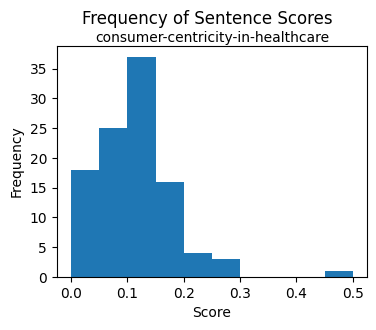

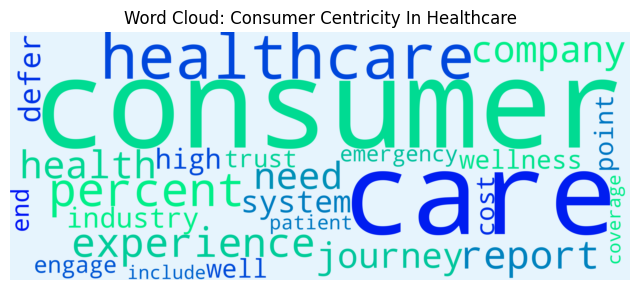

--------------------------------------------------


ARTICLE TITLE: women-in-healthcare.html
--------------------------------------------------

POLARITY RESULTS:
----------------------
Polarity Score: 0.105
Sentiment: Positive

SUMMARIZATION RESULTS: 
----------------------
Top 5 Lemmas:
  1. woman: Count = 118
  2. healthcare: Count = 74
  3. level: Count = 62
  4. representation: Count = 46
  5. rate: Count = 26

Summary: 17 sentences
----------------------
Representation Healthcare continues to outpace other industries in the representation of women however, women especially women of color remain underrepresented at senior levels in healthcare organizations Exhibit 1. Increased representation. At all levels, womens representation in healthcare remains higher than in corporate America overall. Lack of representation in senior levels. But the representation of women drops in each successive career level to a low of 32 percent at the C-suite level. Women in senior-level roles in healt

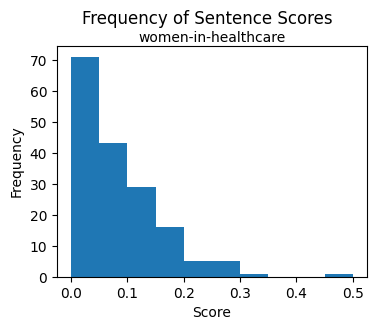

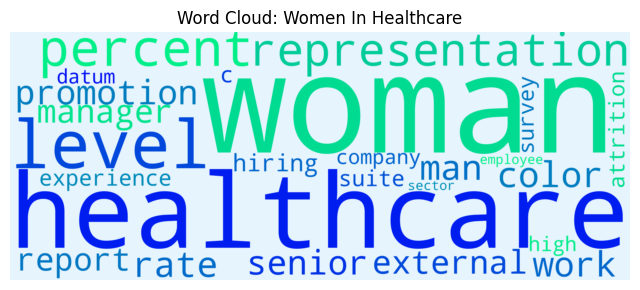

--------------------------------------------------



In [5]:
if __name__ == "__main__":
    
    num = 0
    for a in article_content:
        num +=1
        label = article_labels[num-1]
        
        print()
        print(f"ARTICLE TITLE: {label}") 
        print(dashes)
        print()
        polarity_score(a, label)  
        print()
        summarize_text(a, label)        
        print(dashes)
        print()
